In [112]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [6]:
# Use API to download dataset from Kaggle

import os

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
dataset_id = 'eavannan/daftie-house-price-data'
save_path = '.'
api.dataset_download_files(dataset_id, path=save_path, unzip=True)


In [113]:
df_daft_data = pd.read_csv('daft_ie_v1.csv')

In [114]:
df_daft_data.head()

,id,title,featuredLevel,publishDate,price,numBedrooms,numBathrooms,propertyType,propertySize,category,...,seller_name,seller_branch,sellerType,m_totalImages,m_hasVideo,m_hasVirtualTour,m_hasBrochure,ber_rating,longitude,latitude
0,3626025,"11 Chestnut Crescent, Bridgemount, Carrigaline...",featured,2022-01-28,290000,3,3,End of Terrace,96.0,Buy,...,Roy Dennehy,Dennehy Auctioneers,BRANDED_AGENT,16.0,False,False,False,C2,-8.382500,51.822940
1,3675175,"58 The Glen, Kilnacourt Woods, Portarlington, ...",featured,2022-01-28,225000,3,2,Semi-D,93.0,Buy,...,Marie Kiernan,Tom McDonald & Associates,BRANDED_AGENT,33.0,False,False,False,C1,-7.177098,53.157465
2,3673450,"16 Dodderbrook Park, Ballycullen, Dublin 24",featured,2022-01-27,575000,4,3,Semi-D,162.0,Buy,...,Moovingo,Moovingo,BRANDED_AGENT,38.0,False,True,False,A3,-6.342763,53.269493
3,3649708,"31 Lissanalta Drive, Dooradoyle, Co. Limerick",featured,2022-01-28,299000,3,3,Semi-D,NaN,Buy,...,DNG Cusack Dunne,DNG Cusack Dunne,BRANDED_AGENT,22.0,False,False,False,C2,-8.640716,52.629588
4,3643947,"5 Columba Terrace, Kells, Co. Meath",featured,2022-01-28,120000,3,1,Terrace,68.0,Buy,...,REA T&J Gavigan,REA T & J Gavigan,BRANDED_AGENT,5.0,False,False,False,G,-6.879797,53.728601


In [71]:
# Create a new column 'county'
df_daft_data['county'] = ""

# Iterate over each row in the DataFrame
for index, row in df_daft_data.iterrows():
    title = row['title']
    
    # Extract characters after the final comma
    pattern = r",([^,]*)$"
    result = re.search(pattern, title)
    
    if result:
        county = result.group(1)
        df_daft_data.at[index, 'county'] = county

# Strip out the leading whitespace
df_daft_data['county'] = df_daft_data['county'].str.strip()

In [45]:
# Print the updated DataFrame
df_daft_data.head()

,id,title,featuredLevel,publishDate,price,numBedrooms,numBathrooms,propertyType,propertySize,category,...,seller_branch,sellerType,m_totalImages,m_hasVideo,m_hasVirtualTour,m_hasBrochure,ber_rating,longitude,latitude,county
0,3626025,"11 Chestnut Crescent, Bridgemount, Carrigaline...",featured,2022-01-28,290000,3,3,End of Terrace,96.0,Buy,...,Dennehy Auctioneers,BRANDED_AGENT,16.0,False,False,False,C2,-8.382500,51.822940,Co. Cork
1,3675175,"58 The Glen, Kilnacourt Woods, Portarlington, ...",featured,2022-01-28,225000,3,2,Semi-D,93.0,Buy,...,Tom McDonald & Associates,BRANDED_AGENT,33.0,False,False,False,C1,-7.177098,53.157465,Co. Laois
2,3673450,"16 Dodderbrook Park, Ballycullen, Dublin 24",featured,2022-01-27,575000,4,3,Semi-D,162.0,Buy,...,Moovingo,BRANDED_AGENT,38.0,False,True,False,A3,-6.342763,53.269493,Dublin 24
3,3649708,"31 Lissanalta Drive, Dooradoyle, Co. Limerick",featured,2022-01-28,299000,3,3,Semi-D,NaN,Buy,...,DNG Cusack Dunne,BRANDED_AGENT,22.0,False,False,False,C2,-8.640716,52.629588,Co. Limerick
4,3643947,"5 Columba Terrace, Kells, Co. Meath",featured,2022-01-28,120000,3,1,Terrace,68.0,Buy,...,REA T & J Gavigan,BRANDED_AGENT,5.0,False,False,False,G,-6.879797,53.728601,Co. Meath


In [117]:
df_daft_data.shape

(3967, 22)

In [116]:
# check for missing values
print(df_daft_data.isna().sum().sort_values())

id                    0
ber_rating            0
m_hasBrochure         0
m_hasVirtualTour      0
m_hasVideo            0
m_totalImages         0
sellerType            0
seller_branch         0
seller_name           0
sellerId              0
AMV_price             0
category              0
propertyType          0
numBathrooms          0
numBedrooms           0
price                 0
publishDate           0
featuredLevel         0
title                 0
longitude             0
latitude              0
propertySize        355
dtype: int64


In [74]:
sorted(df_daft_data['county'].unique())

['Co. Carlow',
 'Co. Cavan',
 'Co. Clare',
 'Co. Cork',
 'Co. Donegal',
 'Co. Dublin',
 'Co. Galway',
 'Co. Kerry',
 'Co. Kildare',
 'Co. Kilkenny',
 'Co. Laois',
 'Co. Leitrim',
 'Co. Limerick',
 'Co. Longford',
 'Co. Louth',
 'Co. Mayo',
 'Co. Meath',
 'Co. Monaghan',
 'Co. Offaly',
 'Co. Roscommon',
 'Co. Sligo',
 'Co. Tipperary',
 'Co. Waterford',
 'Co. Westmeath',
 'Co. Wexford',
 'Co. Wicklow',
 'Dublin 1',
 'Dublin 10',
 'Dublin 11',
 'Dublin 12',
 'Dublin 13',
 'Dublin 14',
 'Dublin 15',
 'Dublin 16',
 'Dublin 17',
 'Dublin 18',
 'Dublin 2',
 'Dublin 20',
 'Dublin 22',
 'Dublin 24',
 'Dublin 3',
 'Dublin 4',
 'Dublin 5',
 'Dublin 6',
 'Dublin 6W',
 'Dublin 7',
 'Dublin 8',
 'Dublin 9']

In [73]:
# Do a manual search and replace for the entries where the county info is missing
# I could have just dropped the rows where 'county' was not in the list of actual counties
# but as there were not many I kept them in by manually changing the values

df_daft_data['county'] = df_daft_data['county'].str.replace('Ballinahowen', 'Co. Westmeath')
df_daft_data['county'] = df_daft_data['county'].str.replace('Ballinasloe', 'Co. Galway')
df_daft_data['county'] = df_daft_data['county'].str.replace('Castledaly', 'Co. Westmeath')
df_daft_data['county'] = df_daft_data['county'].str.replace('Charleville', 'Co. Cork')
df_daft_data['county'] = df_daft_data['county'].str.replace('Connemara', 'Co. Galway')
df_daft_data['county'] = df_daft_data['county'].str.replace('Ferrybank', 'Co. Waterford')
df_daft_data['county'] = df_daft_data['county'].str.replace('Lee Road', 'Co. Cork')
df_daft_data['county'] = df_daft_data['county'].str.replace('Lehenaghbeg', 'Co. Cork')
df_daft_data['county'] = df_daft_data['county'].str.replace('Longford', 'Co. Longford')
df_daft_data['county'] = df_daft_data['county'].str.replace('Northern Cross', 'Dublin 17')
df_daft_data['county'] = df_daft_data['county'].str.replace('Our Ladys Island', 'Co. Wexford')
df_daft_data['county'] = df_daft_data['county'].str.replace('Shannonbanks', 'Co. Limerick')
df_daft_data['county'] = df_daft_data['county'].str.replace('The Ward', 'Co. Dublin')
df_daft_data['county'] = df_daft_data['county'].str.replace('Waterford', 'Co. Waterford')
df_daft_data['county'] = df_daft_data['county'].str.replace('Youghal', 'Co. Cork')

# This fixes the places where the above code duplicates the Co.
df_daft_data['county'] = df_daft_data['county'].str.replace('Co. Co. Longford', 'Co. Longford', regex=True)
df_daft_data['county'] = df_daft_data['county'].str.replace('Co. Co. Waterford', 'Co. Waterford', regex=True)

In [87]:
def graph_function(column_name):
    # Get the value counts of the column
    value_counts = df_daft_data[column_name].value_counts()

    # Create the bar plot
    plt.bar(value_counts.index, value_counts.values)

    # Set labels and title
    plt.xlabel(column_name)
    plt.ylabel('Property Count')
    plt.title('Prevalence of ' + column_name)

    # Rotate x-axis labels and reduce label size
    plt.xticks(rotation=90)
    plt.tick_params(axis='x', which='major', labelsize=6)

    # Display the plot
    plt.show()

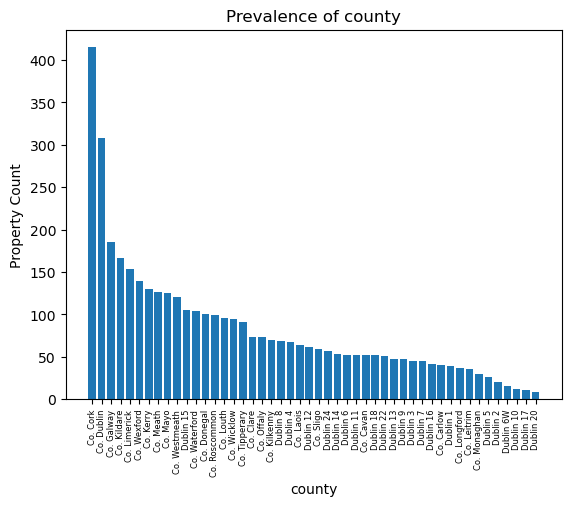

In [88]:
graph_function('county')

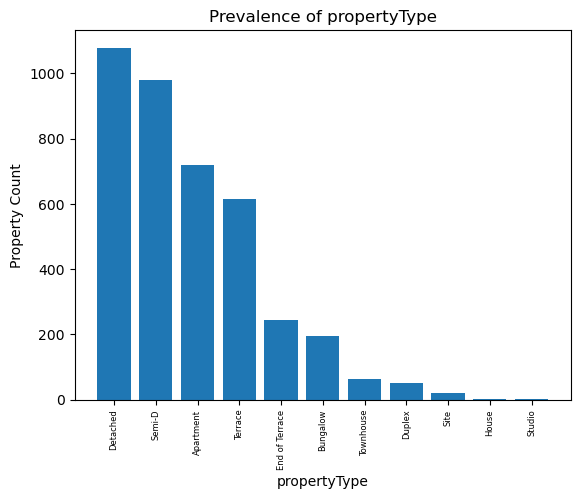

In [89]:
graph_function('propertyType')

id                    0
ber_rating            0
m_hasBrochure         0
m_hasVirtualTour      0
m_hasVideo            0
m_totalImages         0
sellerType            0
seller_branch         0
seller_name           0
sellerId              0
AMV_price             0
category              0
propertyType          0
numBathrooms          0
numBedrooms           0
price                 0
publishDate           0
featuredLevel         0
title                 0
longitude             0
latitude              0
propertySize        355
dtype: int64


In [96]:
# delete the null rows for size

df_daft_data = df_daft_data.dropna(subset=['propertySize'])

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [104]:
# Define the input features (X) and the target variable (y)
features = ['numBedrooms', 'numBathrooms', 'propertyType', 'propertySize',  'county']
target = 'price'

# Encode categorical features
label_encoder = LabelEncoder()
for feature in ['county', 'propertyType', 'ber_rating']:
    df_daft_data[feature] = label_encoder.fit_transform(df_daft_data[feature])

# Split the data into training and testing sets
X = df_daft_data[features]
y = df_daft_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


# Create a random forest regressor model and fit it to the training data
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 29513210902.369682


In [108]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [110]:
# Select features and target variable
features = ['numBedrooms', 'numBathrooms', 'propertyType', 'propertySize',  'county', 'ber_rating']
target = 'price'

# Split the data into training and testing sets
X = df_daft_data[features]
y = df_daft_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost model
model = xgb.XGBRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 29630891961.449074
